In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


## Data Preprocessing

In [19]:
# label tagging to the images

levels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
#path = " ../Users/shaillyvaidya/Desktop/COVID-19_Radiography_Dataset_new"
path = "../COVID-19_Radiography_Dataset_new"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level + '/images')):
        data.append(['{}/images/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'result'])

data['path'] = path + '/' + data['image_file']

data.head()

,image_file,result,path
0,Normal/images/.DS_Store,Normal,../COVID-19_Radiography_Dataset_new/Normal/ima...
1,Normal/images/Normal-1.png,Normal,../COVID-19_Radiography_Dataset_new/Normal/ima...
2,Normal/images/Normal-3.png,Normal,../COVID-19_Radiography_Dataset_new/Normal/ima...
3,Normal/images/Normal-2.png,Normal,../COVID-19_Radiography_Dataset_new/Normal/ima...
4,Normal/images/Normal-4.png,Normal,../COVID-19_Radiography_Dataset_new/Normal/ima...


In [20]:
print("Numbers of X-ray images: {}".format(data.shape[0]))

Numbers of X-ray images: 20


In [5]:
#visualisation

# n_samples = 2

# fig, m_axs = plt.subplots(4, n_samples, figsize = (6*n_samples, 3*4))

# for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['result']).groupby('result')):
#     n_axs[1].set_title(type_name, fontsize = 15)
#     for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):
#         picture = c_row['path']
#         image = cv2.imread(picture)
#         c_ax.imshow(image)
#         c_ax.axis('off')

In [6]:
# sx = sns.countplot(data['result'])
# sx.set_xticklabels(labels=sx.get_xticklabels())
# plt.show()

# print('Normal : ', list(data['result']).count('Normal'))
# print('Covid : ', list(data['result']).count('COVID'))
# print('Opacity : ', list(data['result']).count('Lung_Opacity'))
# print('VIral Pneumonia : ', list(data['result']).count('Viral Pneumonia'))
#10192 images sont normales

In [21]:
round(data['result'].value_counts() / data.shape[0] * 100,2)

result
Normal             25.0
COVID              25.0
Lung_Opacity       25.0
Viral Pneumonia    25.0
Name: count, dtype: float64

# Classification using PIXEL FEATURE extraction

In [22]:
print(data['path'])

0     ../COVID-19_Radiography_Dataset_new/Normal/ima...
1     ../COVID-19_Radiography_Dataset_new/Normal/ima...
2     ../COVID-19_Radiography_Dataset_new/Normal/ima...
3     ../COVID-19_Radiography_Dataset_new/Normal/ima...
4     ../COVID-19_Radiography_Dataset_new/Normal/ima...
5     ../COVID-19_Radiography_Dataset_new/COVID/imag...
6     ../COVID-19_Radiography_Dataset_new/COVID/imag...
7     ../COVID-19_Radiography_Dataset_new/COVID/imag...
8     ../COVID-19_Radiography_Dataset_new/COVID/imag...
9     ../COVID-19_Radiography_Dataset_new/COVID/imag...
10    ../COVID-19_Radiography_Dataset_new/Lung_Opaci...
11    ../COVID-19_Radiography_Dataset_new/Lung_Opaci...
12    ../COVID-19_Radiography_Dataset_new/Lung_Opaci...
13    ../COVID-19_Radiography_Dataset_new/Lung_Opaci...
14    ../COVID-19_Radiography_Dataset_new/Lung_Opaci...
15    ../COVID-19_Radiography_Dataset_new/Viral Pneu...
16    ../COVID-19_Radiography_Dataset_new/Viral Pneu...
17    ../COVID-19_Radiography_Dataset_new/Viral 

In [23]:
pixel_img = []

for image in tqdm(data['path']):
    # Check if the current image is the one to skip
    if image in ['../COVID-19_Radiography_Dataset_new/Normal/images/.DS_Store',
                 '../COVID-19_Radiography_Dataset_new/COVID/images/.DS_Store',
                 '../COVID-19_Radiography_Dataset_new/Lung_Opacity/images/.DS_Store',
                 '../COVID-19_Radiography_Dataset_new/Viral Pneumonia/images/.DS_Store']:
              continue  # Skip this iteration and move to the next image
    img = Image.open(image)
    img = ImageOps.grayscale(img)
    img = img.resize((64, 64))
    img = np.asarray(img)
    img = img.reshape((64, 64, 1))
    pixel_img.append(img)


100%|██████████| 20/20 [00:00<00:00, 364.27it/s]


In [24]:
pixel_img = np.array(pixel_img)
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity' : 2,
                               'Viral Pneumonia' : 3})

print(pixel_img.shape, label_img.shape)

(16, 64, 64, 1) (20,)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img,
                                                    test_size=0.2, stratify=label_img)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

ValueError: Found input variables with inconsistent numbers of samples: [16, 20]

In [ ]:
round(y_train.value_counts() / y_train.shape[0] * 100,2)

result
0    48.16
2    28.40
1    17.09
3     6.35
Name: count, dtype: float64

# Classification using HOG feature extraction

In [ ]:
# Function to extract Hog features from an image
from skimage.feature import hog
def extract_hog_features(image):
    # Convert image to grayscale
    gray = np.array(image)

    # Compute HOG features
    features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), transform_sqrt=True,
                   block_norm='L2-Hys')

    return features

In [ ]:
# Function to process all images in a directory and extract SIFT features
def process_images():
    features = []
    for filename in tqdm(data['path']):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img = Image.open(filename)
            img = ImageOps.grayscale(img)
            img = img.resize((64, 64))
            Hog_features = extract_hog_features(img)
            features.append(Hog_features)

    return features

In [ ]:
class_directory = '../COVID-19_Radiography_Dataset_new'
class_2_features = process_images()
np.save('class_2_features_attempt2.npy', class_2_features)

100%|██████████| 21165/21165 [01:33<00:00, 225.81it/s]


In [ ]:
class_2_features = np.load('../COVID-19_Radiography_Dataset_new/class_2_features_attempt2.npy')

In [ ]:
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity': 2, 'Viral Pneumonia': 3})

In [ ]:
print(class_2_features.shape, label_img.shape)

(21165, 1764) (21165,)


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(class_2_features, label_img,
                                                    test_size=0.2, stratify=label_img)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16932, 1764)
(4233, 1764)
(16932,)
(4233,)


In [ ]:
round(y_train.value_counts() / y_train.shape[0] * 100,2)

result
0    48.16
2    28.40
1    17.09
3     6.35
Name: count, dtype: float64

# MAchine learning model

In [ ]:
# Create instances of the models
svm_model = svm.SVC(kernel='rbf')
logistic_regression = LogisticRegression(max_iter=1000)
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
kn_clas = KNeighborsClassifier()

In [ ]:
#logistic_regression_1 = LogisticRegression(max_iter=1000)

In [ ]:
#logistic_regression.fit(X_train, y_train)

/Users/shaillyvaidya/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Train the models
#logistic_regression_1.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
#xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#kn_clas.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
svm_model.fit(X_train, y_train)

SVC()

# Saving the SVM Model

In [ ]:
import pickle
#svm_model.fit(X_train, y_train)
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)

In [ ]:
# Obtain predictions from the models
# logistic_regression_preds = logistic_regression.predict(X_test)
# logistic_regression_preds_1 = logistic_regression_1.predict(X_test)
# xgb_model_preds = xgb_model.predict(X_test)
# kn_clas_preds = kn_clas.predict(X_test)
svm_model_preds = svm_model.predict(X_test)
# print('Logistic reg',logistic_regression_preds)
# print('Logistic reg 1',logistic_regression_preds_1)
# print('XGB model',xgb_model_preds)
# print('KNN class',kn_clas_preds)
print('SVM',svm_model_preds)

SVM [0 0 0 ... 0 0 1]


In [ ]:
models = [
    #'Logistic Regression',
    # 'Logistic Regression 1',
    #'xgb_model', 
    #'kn_clas' , 
    'svm_model']
predictions = [svm_model_preds]
   # logistic_regression_preds, logistic_regression_preds_1,xgb_model_preds, kn_clas_preds , 


In [ ]:
# # confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

# Assuming you have predicted labels for both X_test and X_tr
acc_test_svm = accuracy_score(y_test, svm_model_preds)*100
# acc_test_log_reg = accuracy_score(y_test, logistic_regression_preds)*100
# acc_test_log_reg_1 = accuracy_score(y_test, logistic_regression_preds_1)*100
# acc_test_xgb = accuracy_score(y_test, xgb_model_preds)*100
# acc_test_knn = accuracy_score(y_test, kn_clas_preds)*100

print(f"Accuracy on test SVM Model set: {acc_test_svm} %")
# print(f"Accuracy on test LR set: {acc_test_log_reg}%")
# print(f"Accuracy on test LR set 1: {acc_test_log_reg_1}%")
# print(f"Accuracy on test XGB Model set: {acc_test_xgb}%")
# print(f"Accuracy on test KNC set: {acc_test_knn}%")

Accuracy on test SVM Model set: 85.44767304512166 %


In [ ]:
report_df = pd.DataFrame(columns=['Model', 'Class', 'Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy'])

In [ ]:
report_df

,Model,Class,Precision,Recall,F1-Score,Support,Accuracy


In [ ]:
# cleaning the report_df of any values it might have
report_df = report_df.drop(index=report_df.index)
for model, preds in zip(models, predictions):
    report = classification_report(y_test, preds, output_dict=True)

    # Extract metrics for each class
    for class_label, metrics in report.items():
        if class_label != 'accuracy':
            report_df = report_df._append({
                'Model': model,
                'Class': class_label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }, ignore_index=True)

# Add accuracy for each model to the DataFrame
#report_df['Accuracy'] = [acc_test_svm] * len(report_df[report_df['Model'] == 'SVM']),[acc_test_log_reg] * len(report_df[report_df['Model'] == 'Logistic Regression']),[acc_test_log_reg_1] * len(report_df[report_df['Model'] == 'Logistic Regression_1']),[acc_test_xgb] * len(report_df[report_df['Model'] == 'XGBoost']),[acc_test_knn] * len(report_df[report_df['Model'] == 'KNN'])

accuracies = [acc_test_svm, 
            #   acc_test_log_reg, 
            #   acc_test_log_reg_1, 
            #   acc_test_xgb, 
            #   acc_test_knn
              ]
accuracy_index = 0

for model in models:
    num_class_labels = len(report_df[report_df['Model'] == model])
    report_df.loc[report_df['Model'] == model, 'Accuracy'] = [accuracies[accuracy_index]] * num_class_labels
    accuracy_index += 1

/var/folders/00/f1dhlfvs2mb_4lg9pdqmxz1m0000gn/T/ipykernel_13664/759076258.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = report_df._append({


In [ ]:
print(report_df)

       Model         Class  Precision    Recall  F1-Score  Support   Accuracy
0  svm_model             0   0.842953  0.924436  0.881816   2038.0  85.447673
1  svm_model             1   0.870066  0.731674  0.794891    723.0  85.447673
2  svm_model             2   0.841873  0.792186  0.816274   1203.0  85.447673
3  svm_model             3   0.972868  0.933086  0.952562    269.0  85.447673
4  svm_model     macro avg   0.881940  0.845345  0.861386   4233.0  85.447673
5  svm_model  weighted avg   0.855533  0.854477  0.852838   4233.0  85.447673


## Displaying the GRAPHS for Accuracy & F1-Scores

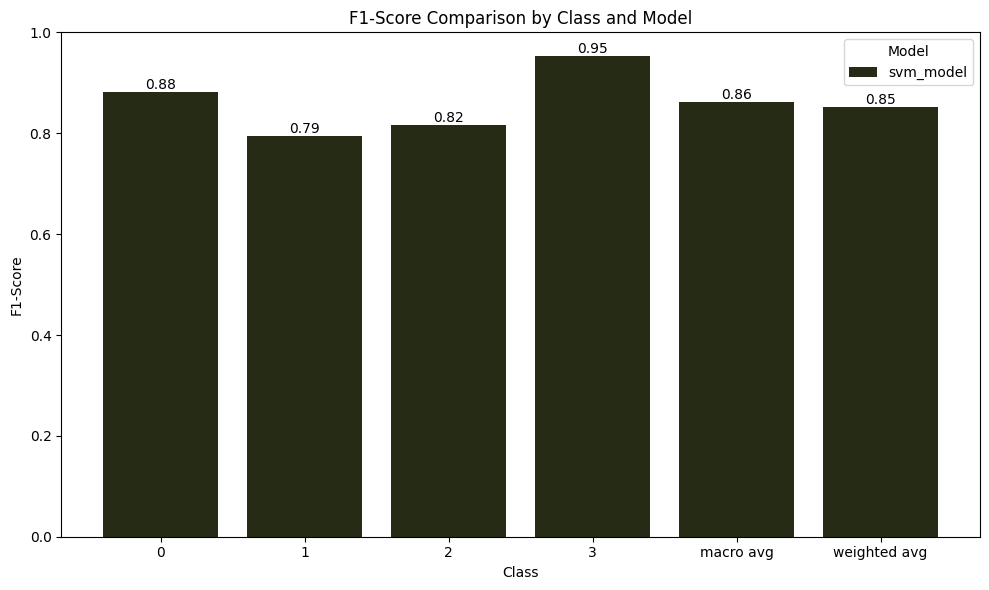

In [ ]:
## DISPLAY F1-SCORES GRAPH
import matplotlib.pyplot as plt
import numpy as np

# Get unique class names and models
# class_names = report_df['Class'].unique()
# model_names = report_df['Model'].unique()

# # Set the number of classes and models
# num_classes = len(class_names)
# num_models = len(model_names)

# # Set the width of each bar
# bar_width = 0.8

# # Set the positions of the bars on the x-axis
# positions = np.arange(num_classes)

# # Set the colors for the models
# colors = ['red', 'blue', 'green', 'orange', 'purple']
# colors = ['#262b15','#3f3f3f','#464b37','#848871','#afb4ad']

# # Create a dictionary to store the F1-Scores for each class
# f1_scores_by_class = {class_name: [] for class_name in class_names}

# # Iterate over each row in the dataframe
# for _, row in report_df.iterrows():
#     class_name = row['Class']
#     f1_score = row['F1-Score']
#     f1_scores_by_class[class_name].append(f1_score)

# # Plot the F1-Scores for each class and model using a grouped bar plot
# plt.figure(figsize=(10, 6))

# # Iterate over each model
# for i, model_name in enumerate(model_names):
#     # Get the F1-Scores for the current model
#     f1_scores = [f1_scores_by_class[class_name][i] for class_name in class_names]
#     # Get the color for the current model
#     color = colors[i % len(colors)]
#     # Calculate the positions for the current model
#     current_positions = positions + (i - num_models / 2 + 0.5) * bar_width / num_models
#     # Plot the bars for the current model
#     plt.bar(current_positions, f1_scores, width=bar_width / num_models, label=model_name, color=color)

#     # Add annotations for each bar
#     for x, y in zip(current_positions, f1_scores):
#         plt.text(x, y, '%.2f' % y, ha='center', va='bottom')
        
# plt.xlabel('Class')
# plt.ylabel('F1-Score')
# plt.title('F1-Score Comparison by Class and Model')
# plt.xticks(positions, class_names)
# plt.legend(title='Model')

# plt.tight_layout()
# plt.show()

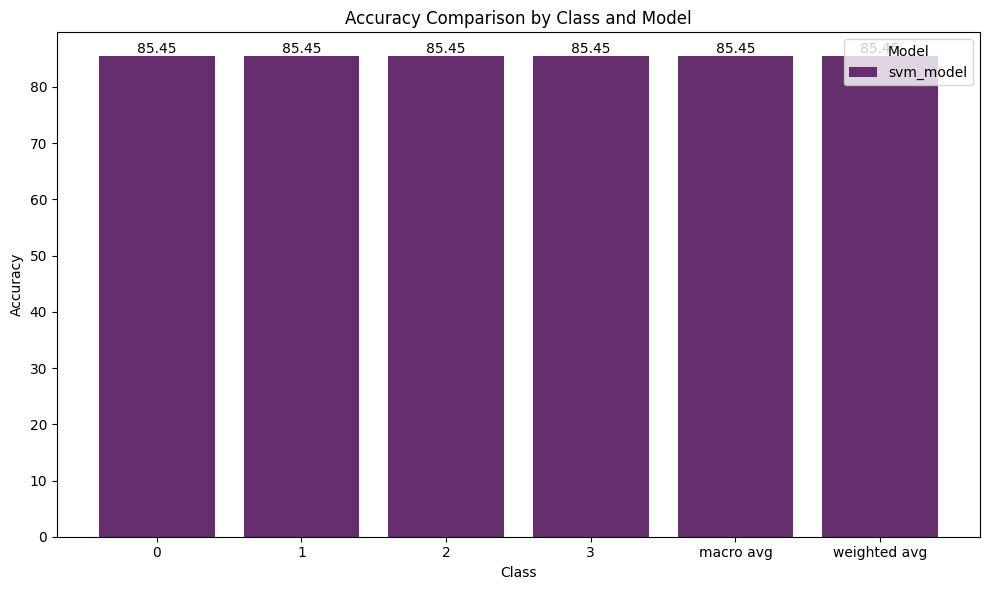

In [ ]:
## DISPLAY ACCURACY GRAPH
import matplotlib.pyplot as plt
import numpy as np

# Get unique class names and models
# class_names = report_df['Class'].unique()
# model_names = report_df['Model'].unique()

# # Set the number of classes and models
# num_classes = len(class_names)
# num_models = len(model_names)

# # Set the width of each bar
# bar_width = 0.8

# # Set the positions of the bars on the x-axis
# positions = np.arange(num_classes)

# # Set the colors for the models
# colors = ['#642F6C','#A2789C','#BA9CC5','#C6B0BC','#B2B4B2', '#D9C89D']

# # Create a dictionary to store the accuracy for each class
# accuracy_by_class = {class_name: [] for class_name in class_names}

# # Iterate over each row in the dataframe
# for _, row in report_df.iterrows():
#     class_name = row['Class']
#     accuracy = row['Accuracy']
#     accuracy_by_class[class_name].append(accuracy)

# # Plot the accuracy for each class and model using a grouped bar plot
# plt.figure(figsize=(10, 6))

# # Iterate over each model
# for i, model_name in enumerate(model_names):
#     # Get the accuracy for the current model
#     accuracies = [accuracy_by_class[class_name][i] for class_name in class_names]
#     # Get the color for the current model
#     color = colors[i % len(colors)]
#     # Calculate the positions for the current model
#     current_positions = positions + (i - num_models / 2 + 0.5) * bar_width / num_models
#     # Plot the bars for the current model
#     plt.bar(current_positions, accuracies, width=bar_width / num_models, label=model_name, color=color)

#     # Add annotations for each bar
#     for x, y in zip(current_positions, accuracies):
#         plt.text(x, y, '%.2f' % y, ha='center', va='bottom')

# plt.xlabel('Class')
# plt.ylabel('Accuracy')
# plt.title('Accuracy Comparison by Class and Model')
# plt.xticks(positions, class_names)
# plt.legend(title='Model')

# plt.tight_layout()
# plt.show()

# Trial 1

In [ ]:
import numpy as np
from PIL import Image, ImageOps
from skimage.feature import hog

def extract_hog_features(image):
    # Convert image to grayscale
    user_input_gray = np.array(image)

    # Compute HOG features
    user_features = hog(user_input_gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), transform_sqrt=True,
                   block_norm='L2-Hys')

    return user_features

def extract_features_from_user_input():
    # Prompt user to input image file path
    image_path = input("Enter the path to the image file: ")

    try:
        # Open the image
        img = Image.open(image_path)
        
        # Convert the image to grayscale
        img_gray = ImageOps.grayscale(img)
        
        # Resize the image to a fixed size (if needed)
        img_resized = img_gray.resize((64, 64))

        # Extract HOG features from the processed image
        user_hog_features = extract_hog_features(img_resized)

        print("User input image path: ", image_path)
        return user_hog_features

    except Exception as e:
        print("Error:", e)
        return None

# Example usage:
user_input_features = extract_features_from_user_input()

if user_input_features is not None:
    print("HOG features extracted successfully!")
    print("Shape of features:", user_input_features.shape)
    # Save or use these features for ML model later


User input image path:  user_image/Lung_Opacity-5.png
HOG features extracted successfully!
Shape of features: (1764,)


In [ ]:
# Assuming you have already loaded and trained all the models (logistic_regression, logistic_regression_1, xgb_model, kn_clas, svm_model)
label_mapping = {
    0: 'Normal',
    1: 'COVID',
    2: 'Lung Opacity',
    3: 'Viral Pneumonia'
}
def predict_with_all_models(user_input_features):
    # Reshape the features to match the expected input shape of the models
    user_input_features_reshaped = user_input_features.reshape(1, -1)

    # Obtain predictions from all models
    # logistic_regression_preds_UI = logistic_regression.predict(user_input_features_reshaped)
    # # logistic_regression_preds_1_UI = logistic_regression_1.predict(user_input_features_reshaped)
    # xgb_model_preds_UI = xgb_model.predict(user_input_features_reshaped)
    # kn_clas_preds_UI = kn_clas.predict(user_input_features_reshaped)
    svm_model_preds_UI = svm_model.predict(user_input_features_reshaped)

    # Map numerical predictions to their corresponding labels
    # logistic_regression_label_UI = label_mapping.get(logistic_regression_preds_UI[0], 'Unknown')
    # # logistic_regression_label_1_UI = label_mapping.get(logistic_regression_preds_1_UI[0], 'Unknown')
    # xgb_model_label_UI = label_mapping.get(xgb_model_preds_UI[0], 'Unknown')
    # kn_clas_label_UI = label_mapping.get(kn_clas_preds_UI[0], 'Unknown')
    svm_model_label_UI = label_mapping.get(svm_model_preds_UI[0], 'Unknown')

    # Display predictions for each model
    # print('Logistic Regression Model Prediction:', logistic_regression_label_UI)
    # # print('Logistic Regression Model 1 Prediction:', logistic_regression_label_1_UI)
    # print('XGBoost Model Prediction:', xgb_model_label_UI)
    # print('K-Nearest Neighbors Model Prediction:', kn_clas_label_UI)
    print('Support Vector Machine Model Prediction:', svm_model_label_UI)

# Example usage:
if user_input_features is not None:
    predict_with_all_models(user_input_features)
else:
    print("Failed to extract features from the user-input image.")

Logistic Regression Model Prediction: Normal
Logistic Regression Model 1 Prediction: Normal
XGBoost Model Prediction: Lung Opacity
K-Nearest Neighbors Model Prediction: Normal
Support Vector Machine Model Prediction: Lung Opacity


# API Call 

In [ ]:
import base64
from flask import Flask, request, jsonify

app = Flask(__name__)

# Define an endpoint for a POST request to make predictions

#wrapper fn
@app.route('/api/predictions', methods=['POST'])

def make_prediction():

    #input image using post method

    # Retrieve the image data from the file
    with open('user_image/COVID-18_test1.png', 'rb') as img_file:
        image_data = img_file.read()

        image_path = request.json.get('image_path')



    def extract_hog_features(image):
    # Convert image to grayscale
        user_input_gray = np.array(image)

# Compute HOG features
        user_features = hog(user_input_gray, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), transform_sqrt=True,
                block_norm='L2-Hys')

        return user_features

    def extract_features_from_user_input():

        try:
            
            # Convert the image to grayscale
            img_gray = ImageOps.grayscale(image_data)
            
            # Resize the image to a fixed size (if needed)
            img_resized = img_gray.resize((64, 64))

            # Extract HOG features from the processed image
            user_hog_features = extract_hog_features(img_resized)

            print("User input image path: Covid")
            return user_hog_features

        except Exception as e:
            print("Error:", e)
            return None

    # Example usage:
    user_input_features = extract_features_from_user_input()

    if user_input_features is not None:
        print("HOG features extracted successfully!")
        print("Shape of features:", user_input_features.shape)
        # Save or use these features for ML model later

    # Assuming you have already loaded and trained all the models (logistic_regression, logistic_regression_1, xgb_model, kn_clas, svm_model)
    label_mapping = {
        0: 'Normal',
        1: 'COVID',
        2: 'Lung Opacity',
        3: 'Viral Pneumonia'
    }
    def predict_with_all_models(user_input_features):
        # Reshape the features to match the expected input shape of the models
        user_input_features_reshaped = user_input_features.reshape(1, -1)

        # Obtain predictions from all models
        svm_model_preds_UI = svm_model.predict(user_input_features_reshaped)

        # Map numerical predictions to their corresponding labels
        svm_model_label_UI = label_mapping.get(svm_model_preds_UI[0], 'Unknown')

        # Display predictions for each model
        print('Support Vector Machine Model Prediction:', svm_model_label_UI)
        return svm_model_label_UI

    # Example usage:
    if user_input_features is not None:
        predictionResults = predict_with_all_models(user_input_features)
    else:
        print("Failed to extract features from the user-input image.")

    # Return the prediction as JSON response
    return predictionResults

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat
Traceback (most recent call last):
  File "/Users/shaillyvaidya/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/shaillyvaidya/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/Users/shaillyvaidya/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
  File "/Users/shaillyvaidya/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 692, in initialize
    self.init_sockets()
  File "/Users/shaillyvaidya/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 331, in init_sockets
    self.shell_port = self._bind_socket(self.shell_socket, self.shell_port)
  File "/Users/shaillyvaidya/Library/Python/3.9/lib/python/sit

SystemExit: 1

/Users/shaillyvaidya/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
